## Import Libraries

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
import datetime

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Dropping Irrelevant Columns

In [4]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [5]:
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']

In [6]:
df = df.drop(columns=columns_to_drop, axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Encode Categorical Variables

In [7]:
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [8]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [9]:
label_encoder_gender = LabelEncoder()
df['Gender'] = label_encoder_gender.fit_transform(df['Gender'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


## One Hot Encoding Geographical Column

In [10]:
geography_one_hot_encoder = OneHotEncoder()
geography_encoder = geography_one_hot_encoder.fit_transform(df[['Geography']])
geography_encoder.toarray()

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [11]:
geography_one_hot_encoder.get_feature_names_out(['Geography'])

array(['Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype=object)

In [12]:
geography_encoded_df = pd.DataFrame(geography_encoder.toarray(), columns=geography_one_hot_encoder.get_feature_names_out(['Geography']))
geography_encoded_df.head()

,Geography_France,Geography_Germany,Geography_Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


## Combining All Columns

In [13]:
df = pd.concat([df.drop('Geography', axis=1), geography_encoded_df], axis=1)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


## Saving the Encoders

In [14]:
with open(file='label_encoder_gender.pkl', mode='wb') as file:
    pickle.dump(label_encoder_gender, file)

with open(file='one_hot_encoder_geography.pkl', mode='wb') as file:
    pickle.dump(geography_one_hot_encoder, file)

## Splitting the Data

In [15]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [16]:
X = df.drop('Exited', axis=1)
y = df['Exited']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Normalizing the Data

In [18]:
scaler = StandardScaler()

In [19]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Saving Scaler File

In [20]:
with open(file='standard_scaler.pkl', mode='wb') as file:
    pickle.dump(scaler, file)

## ANN Implementation

### Building the Model

In [21]:
X_train.shape[1]

12

In [22]:
optimizer = optimizers.Adam(learning_rate=0.01)
loss = losses.BinaryCrossentropy()

In [23]:
model = Sequential()

model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Setup Tensorboard

In [25]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [26]:
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

### Setting Early Stopping

In [27]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### Training the Model

In [28]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
          epochs=100, callbacks=[early_stopping_callback, tensorboard_callback])

Epoch 1/100


250/250 [==============================] - 1s 2ms/step - loss: 0.3991 - accuracy: 0.8339 - val_loss: 0.3419 - val_accuracy: 0.8590
Epoch 2/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3559 - accuracy: 0.8545 - val_loss: 0.3486 - val_accuracy: 0.8605
Epoch 3/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3482 - accuracy: 0.8581 - val_loss: 0.3504 - val_accuracy: 0.8580
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3436 - accuracy: 0.8597 - val_loss: 0.3385 - val_accuracy: 0.8645
Epoch 5/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3376 - accuracy: 0.8596 - val_loss: 0.3389 - val_accuracy: 0.8670
Epoch 6/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3346 - accuracy: 0.8633 - val_loss: 0.3385 - val_accuracy: 0.8610
Epoch 7/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3367 - accuracy: 0.8609 - val_loss: 0.3440 - val_accuracy: 0.85

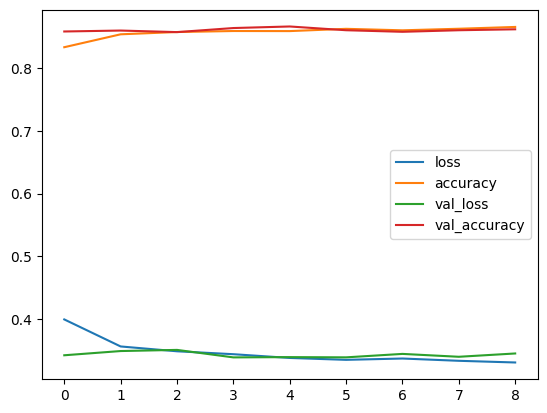

In [29]:
losses_df = pd.DataFrame(model.history.history)
losses_df.plot();

### Saving the Model

In [30]:
model.save('model.keras')

### Loading Tensorboard Extension

In [34]:
# %load_ext tensorboard

In [35]:
# %tensorboard --logdir logs/fit20250212-020100/

### Loading the Pickle File

In [37]:
model = load_model('model.keras')

In [38]:
with open(file='label_encoder_gender.pkl', mode='rb') as file:
    label_encoder = pickle.load(file)

with open(file='one_hot_encoder_geography.pkl', mode='rb') as file:
    one_hot_encoder = pickle.load(file)

with open(file='standard_scaler.pkl', mode='rb') as file:
    scaler = pickle.load(file)

In [39]:
df.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype='object')

### Prediction

In [48]:
input_data = {
    'CreditScore': 600,
    'Geography': 'France',
    'Gender': "Male",
    'Age': 40, 
    'Tenure': 3, 
    'Balance': 60000, 
    'NumOfProducts': 2,
    'HasCrCard': 1, 
    'IsActiveMember': 1, 
    'EstimatedSalary': 50000
}

In [49]:
input_df = pd.DataFrame([input_data])
input_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,600,France,Male,40,3,60000,2,1,1,50000


In [50]:
geography_encoded = one_hot_encoder.transform([[input_data['Geography']]]).toarray()
geography_encoded_df = pd.DataFrame(geography_encoded, columns=one_hot_encoder.get_feature_names_out(['Geography']))
geography_encoded_df

,Geography_France,Geography_Germany,Geography_Spain
0,1.0,0.0,0.0


In [51]:
input_df = pd.concat(
    [
        input_df.drop('Geography', axis=1),
        geography_encoded_df
    ],
    axis=1
)
input_df

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,600,Male,40,3,60000,2,1,1,50000,1.0,0.0,0.0


In [52]:
input_df['Gender'] = label_encoder.transform(input_df['Gender'])
input_df

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,600,1,40,3,60000,2,1,1,50000,1.0,0.0,0.0


In [53]:
input_data = scaler.transform(input_df)
input_data

array([[-0.53598516,  0.91324755,  0.10479359, -0.69539349, -0.25781119,
         0.80843615,  0.64920267,  0.97481699, -0.87683221,  1.00150113,
        -0.57946723, -0.57638802]])

In [57]:
prediction = (model.predict(input_data) > 0.5).astype(int)
prediction[0][0]

1/1 [==============================] - 0s 13ms/step


0